In [801]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Reshape, Concatenate, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [802]:
# Data loading and preprocessing
xie_1 = pd.read_csv(r'D:\deep\老师中期项目\新思路_新模型1021\A_投稿代码\马英杰的\well_log.csv', encoding='ANSI')
print(xie_1.columns)

Index(['CNL_Z', 'Density_0108', 'GR_Z', 'P-wave_0108', 'S-wave_0108'], dtype='object')


In [803]:
# Normalization (automatic normalization)
scalers = {}  # Dictionary to store scalers for inverse transformation later
for col in xie_1.columns[:13]:
    scaler = MinMaxScaler()  
    xie_1[col] = scaler.fit_transform(xie_1[col].values.reshape(-1,1))
    scalers[col] = scaler  # Store scaler for later use

In [804]:
# Convert from dataframe to array
xie_1_1 = np.array(xie_1)  # Extract features - xie_1
data = xie_1_1
cnl = data[:,0]   # CNL_Z corresponding to index 1
den = data[:,1]   # Density_0108 corresponding to index 2
gr = data[:,2]    # GR_Z corresponding to index 3
vp = data[:,3]    # P-wave_0108 corresponding to index 7
vs = data[:,4]    # S-wave_0108 corresponding to index 11

vp0 = np.expand_dims(vp, 1)
vs0 = np.expand_dims(vs, 1)
den0 = np.expand_dims(den, 1)
vpvsden = np.concatenate((vp0, vs0, den0), axis=1)
print(vpvsden.shape)

gr0 = np.expand_dims(gr, 1)
cnl0 = np.expand_dims(cnl, 1)
grcnl = np.concatenate((gr0, cnl0), axis=1)
print(grcnl.shape)

(1361, 3)
(1361, 2)


In [805]:
# Create multi-output feature dataset
def create_dataset_multi_output(X, y1, y2, seq_len):
    """
    Create multi-output dataset
    X: input features
    y1: first output (gr)
    y2: second output (cnl)
    seq_len: sequence length
    """
    features = []
    targets_gr = []
    targets_cnl = []
    
    for i in range(0, len(X) - seq_len, 1):  # 1 is the step size
        data = X[i:i+seq_len]  # Sequence data  
        label_gr = y1[i+seq_len//2]  # gr label data
        label_cnl = y2[i+seq_len//2]  # cnl label data
        # Save to features and labels
        features.append(data)
        targets_gr.append(label_gr)
        targets_cnl.append(label_cnl)
    
    # Return
    return np.array(features), np.array(targets_gr), np.array(targets_cnl)  # Return samples and two label

In [806]:
# Sequence length of 11, create new dataset with labels
Len1 = 9
# Modified: use vpvsden as input, gr and cnl as output
(x1, y1_gr, y1_cnl) = create_dataset_multi_output(vpvsden, gr, cnl, Len1)  # Modified: use vpvsden to predict gr and cnl
print(x1.shape, y1_gr.shape, y1_cnl.shape)

x1 = x1.reshape(x1.shape[0], x1.shape[1]*x1.shape[2])
print(x1.shape)

(1352, 9, 3) (1352,) (1352,)
(1352, 27)


In [807]:
# Define multi-output STABGCN model
def build_multi_output_stabgcn_model(input_shape):
    """
    Multi-output STABGCN model for simultaneous GR and CNL prediction
    """
    # Input layer
    inputs = Input(shape=input_shape)
    features = input_shape[0]
    
    # ------- 2D-CNN branch -------
    # Reshape to square image
    side_length = int(np.ceil(np.sqrt(features)))
    padding_needed = side_length * side_length - features
    
    x_padded = tf.pad(inputs, [[0, 0], [0, padding_needed]])
    reshaped_2d = Reshape((side_length, side_length, 1))(x_padded)
    
    # Convolutional layers
    conv2d = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same',
                   kernel_regularizer=tf.keras.regularizers.l2(0.001))(reshaped_2d)
    pool = MaxPooling2D(pool_size=(2, 2))(conv2d)
    dropout_cnn = Dropout(0.2)(pool)
    cnn_flat = Flatten()(dropout_cnn)
    
    # ------- BiGRU branch -------
    # Build sequence representation
    seq_length = features // 3  # For vpvsden, each time step has 3 features (vp, vs, den)
    
    # Reshape to sequence
    x_seq = Reshape((seq_length, 3))(inputs[:, :seq_length*3])  # Each time step has 3 features
    
    # BiGRU layer
    bigru = Bidirectional(GRU(32, 
                            recurrent_regularizer=tf.keras.regularizers.l2(0.001),
                            kernel_regularizer=tf.keras.regularizers.l2(0.001)))(x_seq)
    dropout_gru = Dropout(0.2)(bigru)
    
    # Merge features
    merged = Concatenate()([cnn_flat, dropout_gru])
    
    # Shared layers
    shared = Dense(128, activation='relu', 
                  kernel_regularizer=tf.keras.regularizers.l2(0.001))(merged)
    shared_dropout = Dropout(0.2)(shared)
    
    # Branch network - GR prediction
    gr_branch = Dense(64, activation='relu', 
                     kernel_regularizer=tf.keras.regularizers.l2(0.001))(shared_dropout)
    gr_dropout = Dropout(0.2)(gr_branch)
    gr_output = Dense(1, name='gr_output')(gr_dropout)  # GR output
    
    # Branch network - CNL prediction
    cnl_branch = Dense(64, activation='relu', 
                      kernel_regularizer=tf.keras.regularizers.l2(0.001))(shared_dropout)
    cnl_dropout = Dropout(0.2)(cnl_branch)
    cnl_output = Dense(1, name='cnl_output')(cnl_dropout)  # CNL output
    
    # Create model with two outputs
    model = Model(inputs=inputs, outputs=[gr_output, cnl_output])
    
    # Learning rate decay
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=100,
        decay_rate=0.9)
    
    optimizer = Adam(learning_rate=lr_schedule)
    
    # Compile model with MSE loss for both outputs
    model.compile(
        optimizer=optimizer, 
        loss={'gr_output': 'mse', 'cnl_output': 'mse'},
        loss_weights={'gr_output': 1.0, 'cnl_output': 1}  # Equal weights for both outputs
    )
    
    return model


In [808]:
# Define data shape
features = Len1*3  # Input feature dimensions, Len1*3 (because vpvsden has 3 features per time step)
input_shape = (features,)  # Define input shape

# Build model
model3 = build_multi_output_stabgcn_model(input_shape)

# Output model structure
model3.summary()

Model: "model_58"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_59 (InputLayer)           [(None, 27)]         0                                            
__________________________________________________________________________________________________
tf_op_layer_Pad_58 (TensorFlowO [(None, 36)]         0           input_59[0][0]                   
__________________________________________________________________________________________________
reshape_116 (Reshape)           (None, 6, 6, 1)      0           tf_op_layer_Pad_58[0][0]         
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 6, 6, 32)     320         reshape_116[0][0]                
___________________________________________________________________________________________

In [809]:
# Data preparation
source_points = x1
target_points_gr = y1_gr
target_points_cnl = y1_cnl
print(source_points.shape, target_points_gr.shape, target_points_cnl.shape)

# Standardize data
scaler = StandardScaler()
source_points_scaled = scaler.fit_transform(source_points)

(1352, 27) (1352,) (1352,)


In [810]:
# Split data into training and testing sets
X_train, X_test, y_train_gr, y_test_gr, y_train_cnl, y_test_cnl = train_test_split(
    source_points_scaled, target_points_gr, target_points_cnl, test_size=0.15, random_state=42
)
print(X_train.shape, X_test.shape, y_train_gr.shape, y_test_gr.shape, y_train_cnl.shape, y_test_cnl.shape)

# Train model - multi-output
history = model3.fit(
    X_train, 
    {'gr_output': y_train_gr, 'cnl_output': y_train_cnl}, 
    epochs=15, 
    batch_size=100, 
    validation_split=0.05, 
    verbose=1
)

# Evaluate model - multi-output
eval_results = model3.evaluate(
    X_test, 
    {'gr_output': y_test_gr, 'cnl_output': y_test_cnl},
    verbose=1
)
print(f'Test Loss: {eval_results}')

(1149, 27) (203, 27) (1149,) (203,) (1149,) (203,)
Train on 1091 samples, validate on 58 samples
Epoch 1/15
1091/1091 [==============================] - 3s 2ms/sample - loss: 0.6764 - gr_output_loss: 0.1625 - cnl_output_loss: 0.0872 - val_loss: 0.5551 - val_gr_output_loss: 0.1133 - val_cnl_output_loss: 0.0266
Epoch 2/15
1091/1091 [==============================] - 0s 106us/sample - loss: 0.5375 - gr_output_loss: 0.0905 - cnl_output_loss: 0.0407 - val_loss: 0.4539 - val_gr_output_loss: 0.0448 - val_cnl_output_loss: 0.0141
Epoch 3/15
1091/1091 [==============================] - 0s 76us/sample - loss: 0.4738 - gr_output_loss: 0.0624 - cnl_output_loss: 0.0255 - val_loss: 0.4380 - val_gr_output_loss: 0.0509 - val_cnl_output_loss: 0.0124
Epoch 4/15
1091/1091 [==============================] - 0s 92us/sample - loss: 0.4344 - gr_output_loss: 0.0469 - cnl_output_loss: 0.0216 - val_loss: 0.4055 - val_gr_output_loss: 0.0378 - val_cnl_output_loss: 0.0126
Epoch 5/15
1091/1091 [=====================

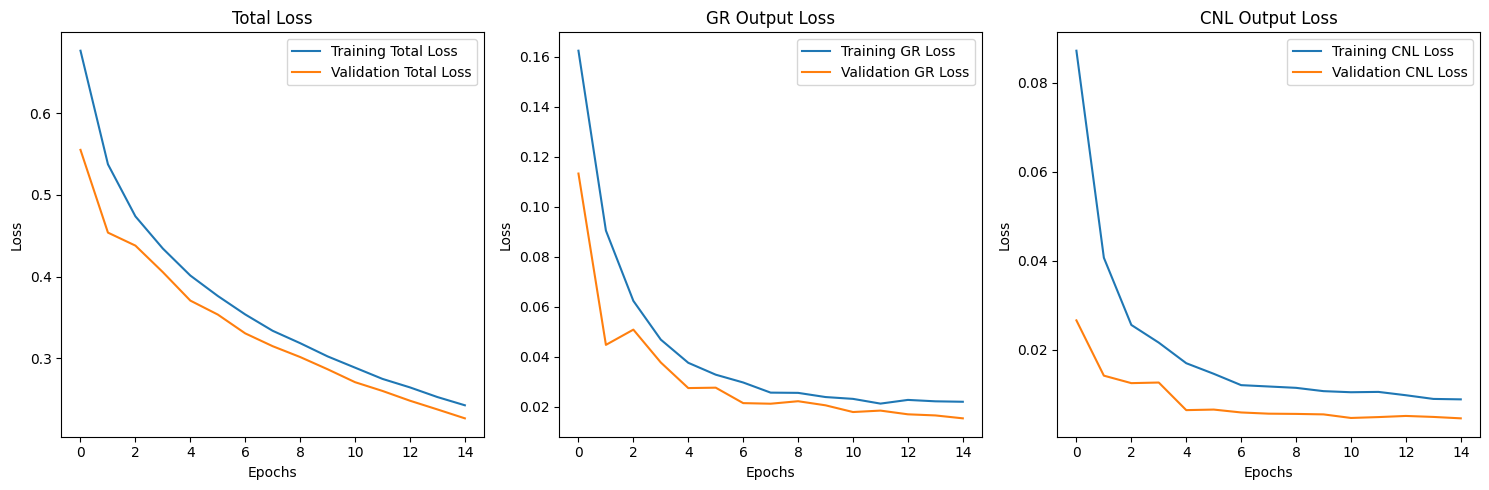

In [811]:
# Plot training loss and validation loss vs epochs - multi-output
plt.figure(figsize=(15, 5))

# Plot total loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Total Loss')
plt.plot(history.history['val_loss'], label='Validation Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Total Loss')
plt.legend()

# Plot GR output loss
plt.subplot(1, 3, 2)
plt.plot(history.history['gr_output_loss'], label='Training GR Loss')
plt.plot(history.history['val_gr_output_loss'], label='Validation GR Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GR Output Loss')
plt.legend()

# Plot CNL output loss
plt.subplot(1, 3, 3)
plt.plot(history.history['cnl_output_loss'], label='Training CNL Loss')
plt.plot(history.history['val_cnl_output_loss'], label='Validation CNL Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNL Output Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [812]:
# Generate predictions on test data - multi-output
# Make predictions on the test set instead of the entire dataset
predictions = model3.predict(X_test)
gr_predictions = predictions[0]  # GR predictions
cnl_predictions = predictions[1]  # CNL predictions

In [813]:
# Get the column names for GR and CNL from the original dataframe
gr_column_name = xie_1.columns[2]  # GR_Z is at index 2
cnl_column_name = xie_1.columns[0]  # CNL_Z is at index 0

# Inverse transform predictions and labels using stored scalers
gr_scaler = scalers[gr_column_name]
cnl_scaler = scalers[cnl_column_name]

# Reshape for inverse transform
gr_predictions_denorm = gr_scaler.inverse_transform(gr_predictions)
gr_actual_denorm = gr_scaler.inverse_transform(y_test_gr.reshape(-1, 1))

cnl_predictions_denorm = cnl_scaler.inverse_transform(cnl_predictions)
cnl_actual_denorm = cnl_scaler.inverse_transform(y_test_cnl.reshape(-1, 1))


GR R² Score (denormalized test data): 0.4217599308218726
CNL R² Score (denormalized test data): 0.6418127287928458


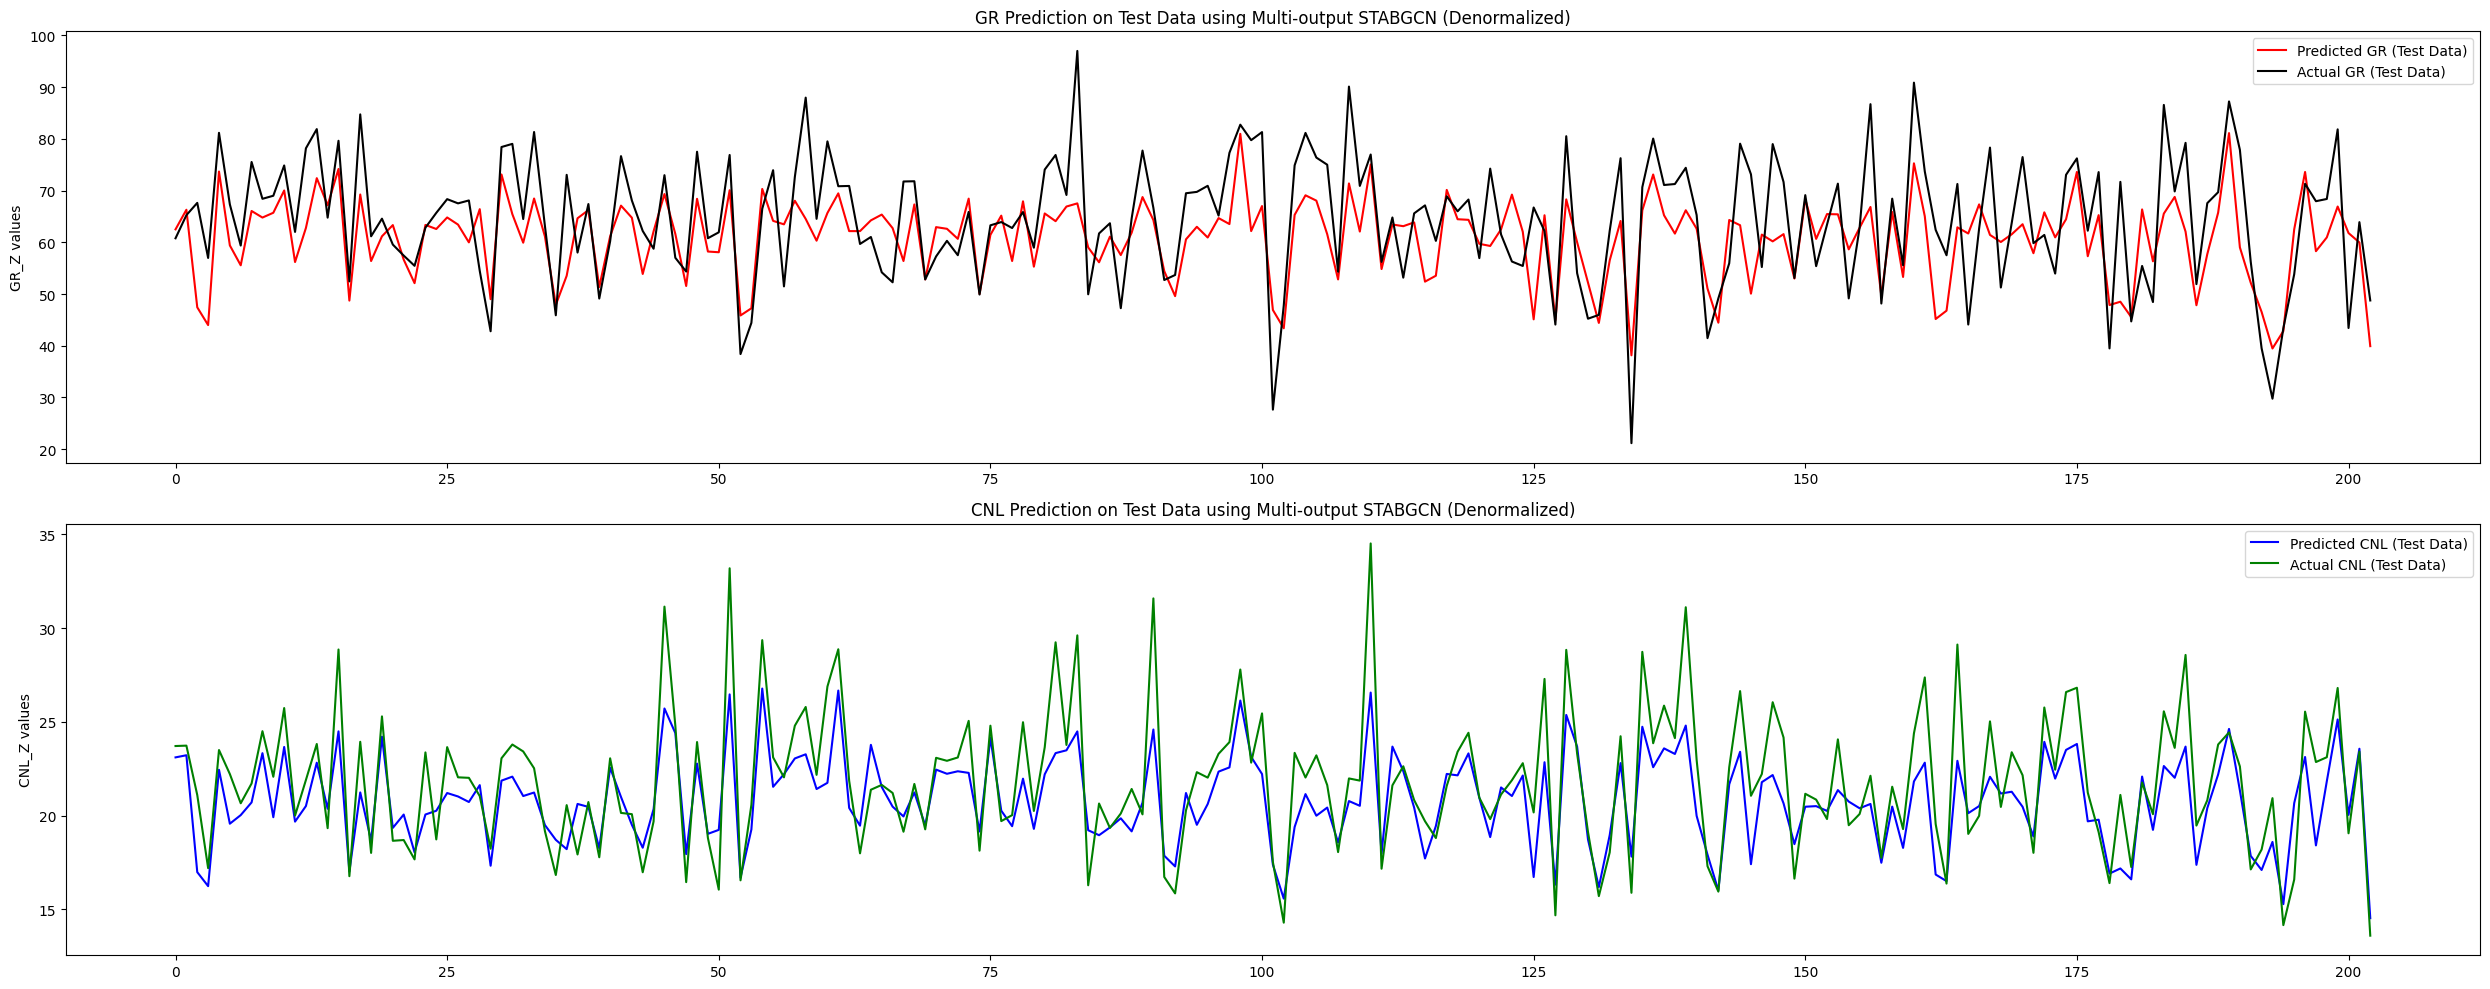

In [814]:

# Calculate R² scores with denormalized test data
r2_gr = r2_score(gr_actual_denorm, gr_predictions_denorm)
print(f'GR R² Score (denormalized test data): {r2_gr}')

r2_cnl = r2_score(cnl_actual_denorm, cnl_predictions_denorm)
print(f'CNL R² Score (denormalized test data): {r2_cnl}')
# Plot - GR prediction results with denormalized test data
plt.figure(figsize=(25, 10))
plt.subplot(2, 1, 1)
plt.plot(gr_predictions_denorm, 'r', label='Predicted GR (Test Data)')
plt.plot(gr_actual_denorm, 'k', label='Actual GR (Test Data)')
plt.title('GR Prediction on Test Data using Multi-output STABGCN (Denormalized)')
plt.legend()
plt.ylabel(f'{gr_column_name} values')

# Plot - CNL prediction results with denormalized test data
plt.subplot(2, 1, 2)
plt.plot(cnl_predictions_denorm, 'b', label='Predicted CNL (Test Data)')
plt.plot(cnl_actual_denorm, 'g', label='Actual CNL (Test Data)')
plt.title('CNL Prediction on Test Data using Multi-output STABGCN (Denormalized)')
plt.legend()
plt.ylabel(f'{cnl_column_name} values')

plt.tight_layout()
plt.show()